# Test Data

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.linear import TaylorFirstOrder, TaylorSecondOrder

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [11]:
from pathlib import Path
import pandas as pd

data_dir = Path("/Users/eman/Desktop/ERCData/papers/2020_LAI_FAPAR_errorPropagarion_IGARSS_ANN_MODIS/Data")

# load trainind data
train_data_file = "trainingdataRegression.csv"
data_train = pd.read_csv(str(data_dir.joinpath(train_data_file)))

In [7]:
!ls $data_dir

training.mat
trainingMOD15.txt
trainingdataRegression.csv
trainingdataRegressionMoreDATA.csv
trainingdataRegressionMuchmoreDATA.csv
trainingdataRegressionaddedpredictionerror.csv
trainingmuchmoredata.mat
trainingmuchmoredataaddedpredError.mat
trainingmuchmoredataaddedpredError1.csv
trainingmuchmoredataaddedpredError2.csv


In [12]:
data_train.head()

,system:index,B1_post,B2_post,B3_post,B4_post,B5_post,B7_post,Fpar,Fpar_stdDev,Lai,Lai_stdDev,Land_Cover_Type_1,latitude,longitude,month,.geo
0,0_0,830.0,1065.0,1248.0,2101.0,2143.0,1366.0,18.0,9.0,2.0,1.0,10,37.155892,-104.733007,1,"{""type"":""Point"",""coordinates"":[-104.7330069237..."
1,0_1,1084.0,1367.0,1625.0,2562.0,3474.0,2688.0,20.0,0.0,3.0,0.0,10,47.937023,-111.795113,1,"{""type"":""Point"",""coordinates"":[-111.7951125298..."
2,0_2,774.0,961.0,1238.0,1806.0,2237.0,1640.0,NaN,NaN,NaN,NaN,10,48.397859,-109.891133,1,"{""type"":""Point"",""coordinates"":[-109.8911332851..."
3,0_3,NaN,1514.0,1592.0,1814.0,1254.0,830.0,9.0,0.0,1.0,0.0,14,43.983538,-92.334909,1,"{""type"":""Point"",""coordinates"":[-92.33490852997..."
4,0_4,806.0,1051.0,1238.0,2339.0,2695.0,1821.0,30.0,0.0,3.0,0.0,14,41.339796,-82.309710,1,"{""type"":""Point"",""coordinates"":[-82.30970995919..."


In [13]:
data_train.describe()

,B1_post,B2_post,B3_post,B4_post,B5_post,B7_post,Fpar,Fpar_stdDev,Lai,Lai_stdDev,Land_Cover_Type_1,latitude,longitude,month
count,4366.000000,4386.000000,4388.000000,4448.000000,4429.000000,4401.000000,4460.000000,4460.000000,4460.000000,4460.000000,6000.000000,6000.000000,6000.000000,6000.00000
mean,643.159185,871.023028,981.048769,2480.714703,2284.244525,1515.993865,43.808744,4.769507,12.776233,2.486996,7.430000,39.272462,-94.327368,6.50000
std,279.947849,352.212407,513.100866,675.158173,717.212722,711.931212,23.834086,4.209768,13.570054,3.921358,4.897458,5.616699,15.357429,3.45234
min,173.000000,237.000000,175.000000,714.000000,230.000000,136.000000,5.000000,0.000000,1.000000,0.000000,0.000000,24.620352,-124.512562,1.00000
25%,429.000000,603.000000,573.000000,2001.750000,1794.000000,955.000000,23.000000,2.000000,3.000000,0.000000,4.000000,35.065962,-107.051334,3.75000
50%,591.000000,805.000000,885.000000,2378.000000,2253.000000,1433.000000,42.000000,4.000000,7.000000,1.000000,8.000000,39.320607,-91.706312,6.50000
75%,804.000000,1061.750000,1289.000000,2882.250000,2774.000000,1966.000000,62.000000,7.000000,16.000000,3.000000,12.000000,43.915827,-82.195512,9.25000
max,2392.000000,3030.000000,3439.000000,5302.000000,4677.000000,4423.000000,95.000000,33.000000,66.000000,24.000000,16.000000,49.376124,-64.163292,12.00000


In [149]:
# load trainind data
train_data_file = "trainingdataRegressionaddedpredictionerror.csv"
test_data_file = "trainingdataRegressionaddedpredictionerror.csv" 
data_train_l = pd.read_csv(str(data_dir.joinpath(train_data_file)))
data_train_l_ = data_train_l.dropna()

In [150]:
data_train_l_.head()

,system:index,B1_post,B2_post,B3_post,B4_post,B5_post,B7_post,Fpar,Fpar_stdDev,Lai,...,P1_postSD,P2_postSD,P3_postSD,P4_postSD,P5_postSD,P7_postSD,latitude,longitude,month,.geo
0,0_0,830.0,1065.0,1248.0,2101.0,2143.0,1366.0,18.0,9.0,2.0,...,155.0,161.0,170.0,188.0,236.0,174.0,37.155892,-104.733007,1.0,"{""type"":""Point"",""coordinates"":[-104.7330069237..."
1,0_1,1084.0,1367.0,1625.0,2562.0,3474.0,2688.0,20.0,0.0,3.0,...,170.0,185.0,237.0,282.0,362.0,278.0,47.937023,-111.795113,1.0,"{""type"":""Point"",""coordinates"":[-111.7951125298..."
4,0_4,806.0,1051.0,1238.0,2339.0,2695.0,1821.0,30.0,0.0,3.0,...,62.0,68.0,90.0,220.0,244.0,192.0,41.339796,-82.309710,1.0,"{""type"":""Point"",""coordinates"":[-82.30970995919..."
5,0_5,424.0,543.0,619.0,1844.0,1923.0,1136.0,54.0,6.0,10.0,...,67.0,79.0,83.0,225.0,201.0,152.0,34.483853,-85.943844,1.0,"{""type"":""Point"",""coordinates"":[-85.94384444110..."
6,0_6,758.0,1028.0,1337.0,2201.0,2856.0,1915.0,29.0,0.0,3.0,...,83.0,100.0,134.0,188.0,259.0,229.0,39.755167,-94.020597,1.0,"{""type"":""Point"",""coordinates"":[-94.02059716062..."


In [151]:
data_train_l_.describe()

,B1_post,B2_post,B3_post,B4_post,B5_post,B7_post,Fpar,Fpar_stdDev,Lai,Lai_stdDev,Land_Cover_Type_1,P1_postSD,P2_postSD,P3_postSD,P4_postSD,P5_postSD,P7_postSD,latitude,longitude,month
count,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000,41430.000000
mean,633.992349,867.033599,981.466401,2480.748033,2304.418248,1538.872894,42.551315,4.630847,12.443712,2.376804,8.899903,94.382090,105.974511,130.168622,230.885083,236.647478,184.972797,39.012194,-98.812294,6.638137
std,270.793812,357.762641,524.932003,658.103701,723.874209,738.051339,24.052520,4.256818,13.590816,3.886098,3.637201,65.918081,67.745239,80.046106,126.827884,128.013423,111.162151,5.024366,13.426668,3.279519
min,161.000000,207.000000,150.000000,544.000000,220.000000,111.000000,5.000000,0.000000,1.000000,0.000000,0.000000,19.000000,25.000000,19.000000,22.000000,20.000000,14.000000,25.331817,-124.249805,1.000000
25%,421.000000,593.000000,560.000000,2013.000000,1776.000000,936.000000,22.000000,2.000000,3.000000,0.000000,7.000000,64.000000,71.000000,83.000000,159.000000,159.000000,114.000000,35.029580,-109.365619,4.000000
50%,583.000000,799.000000,883.000000,2375.000000,2283.000000,1449.000000,40.000000,4.000000,7.000000,1.000000,10.000000,81.000000,92.000000,113.000000,206.000000,208.000000,157.000000,38.837538,-98.693633,7.000000
75%,790.000000,1056.000000,1295.000000,2858.000000,2819.000000,2031.000000,61.000000,6.000000,16.000000,3.000000,12.000000,104.000000,120.000000,155.000000,274.000000,281.000000,227.000000,43.045696,-88.201535,9.000000
max,3420.000000,3381.000000,3460.000000,5525.000000,4832.000000,4598.000000,97.000000,35.000000,68.000000,27.000000,16.000000,2813.000000,2450.000000,1778.000000,3325.000000,2753.000000,1882.000000,48.975925,-67.647857,12.000000


In [152]:
x_columns = [
    "B1_post",
    "B2_post",
    "B3_post",
    "B4_post",
    "B5_post",
    "B7_post",
]
x_std_columns = [
    "P1_postSD",
    "P2_postSD",
    "P3_postSD",
    "P4_postSD",
    "P5_postSD",
    "P7_postSD"
]
y_columns = [
    "Lai",
    "Fpar",
]
y_std_columns = [
    "Lai_stdDev",
    "Fpar_stdDev"
]
meta = [
    "latitude",
    "longitude",
    "month",
    "Land_Cover_Type_1"
]

In [ ]:
data_train_l_.sort_values

In [176]:
# data_train = data_train_l_.sort_values(['latitude', 'longitude', "month", "Land_Cover_Type_1"], ascending=[True, True, True, True])
data_train = data_train_l_.set_index(meta).sort_index()

In [177]:
X = data_train[x_columns]
y = data_train[y_columns]

X.shape, y.shape

((41430, 6), (41430, 2))

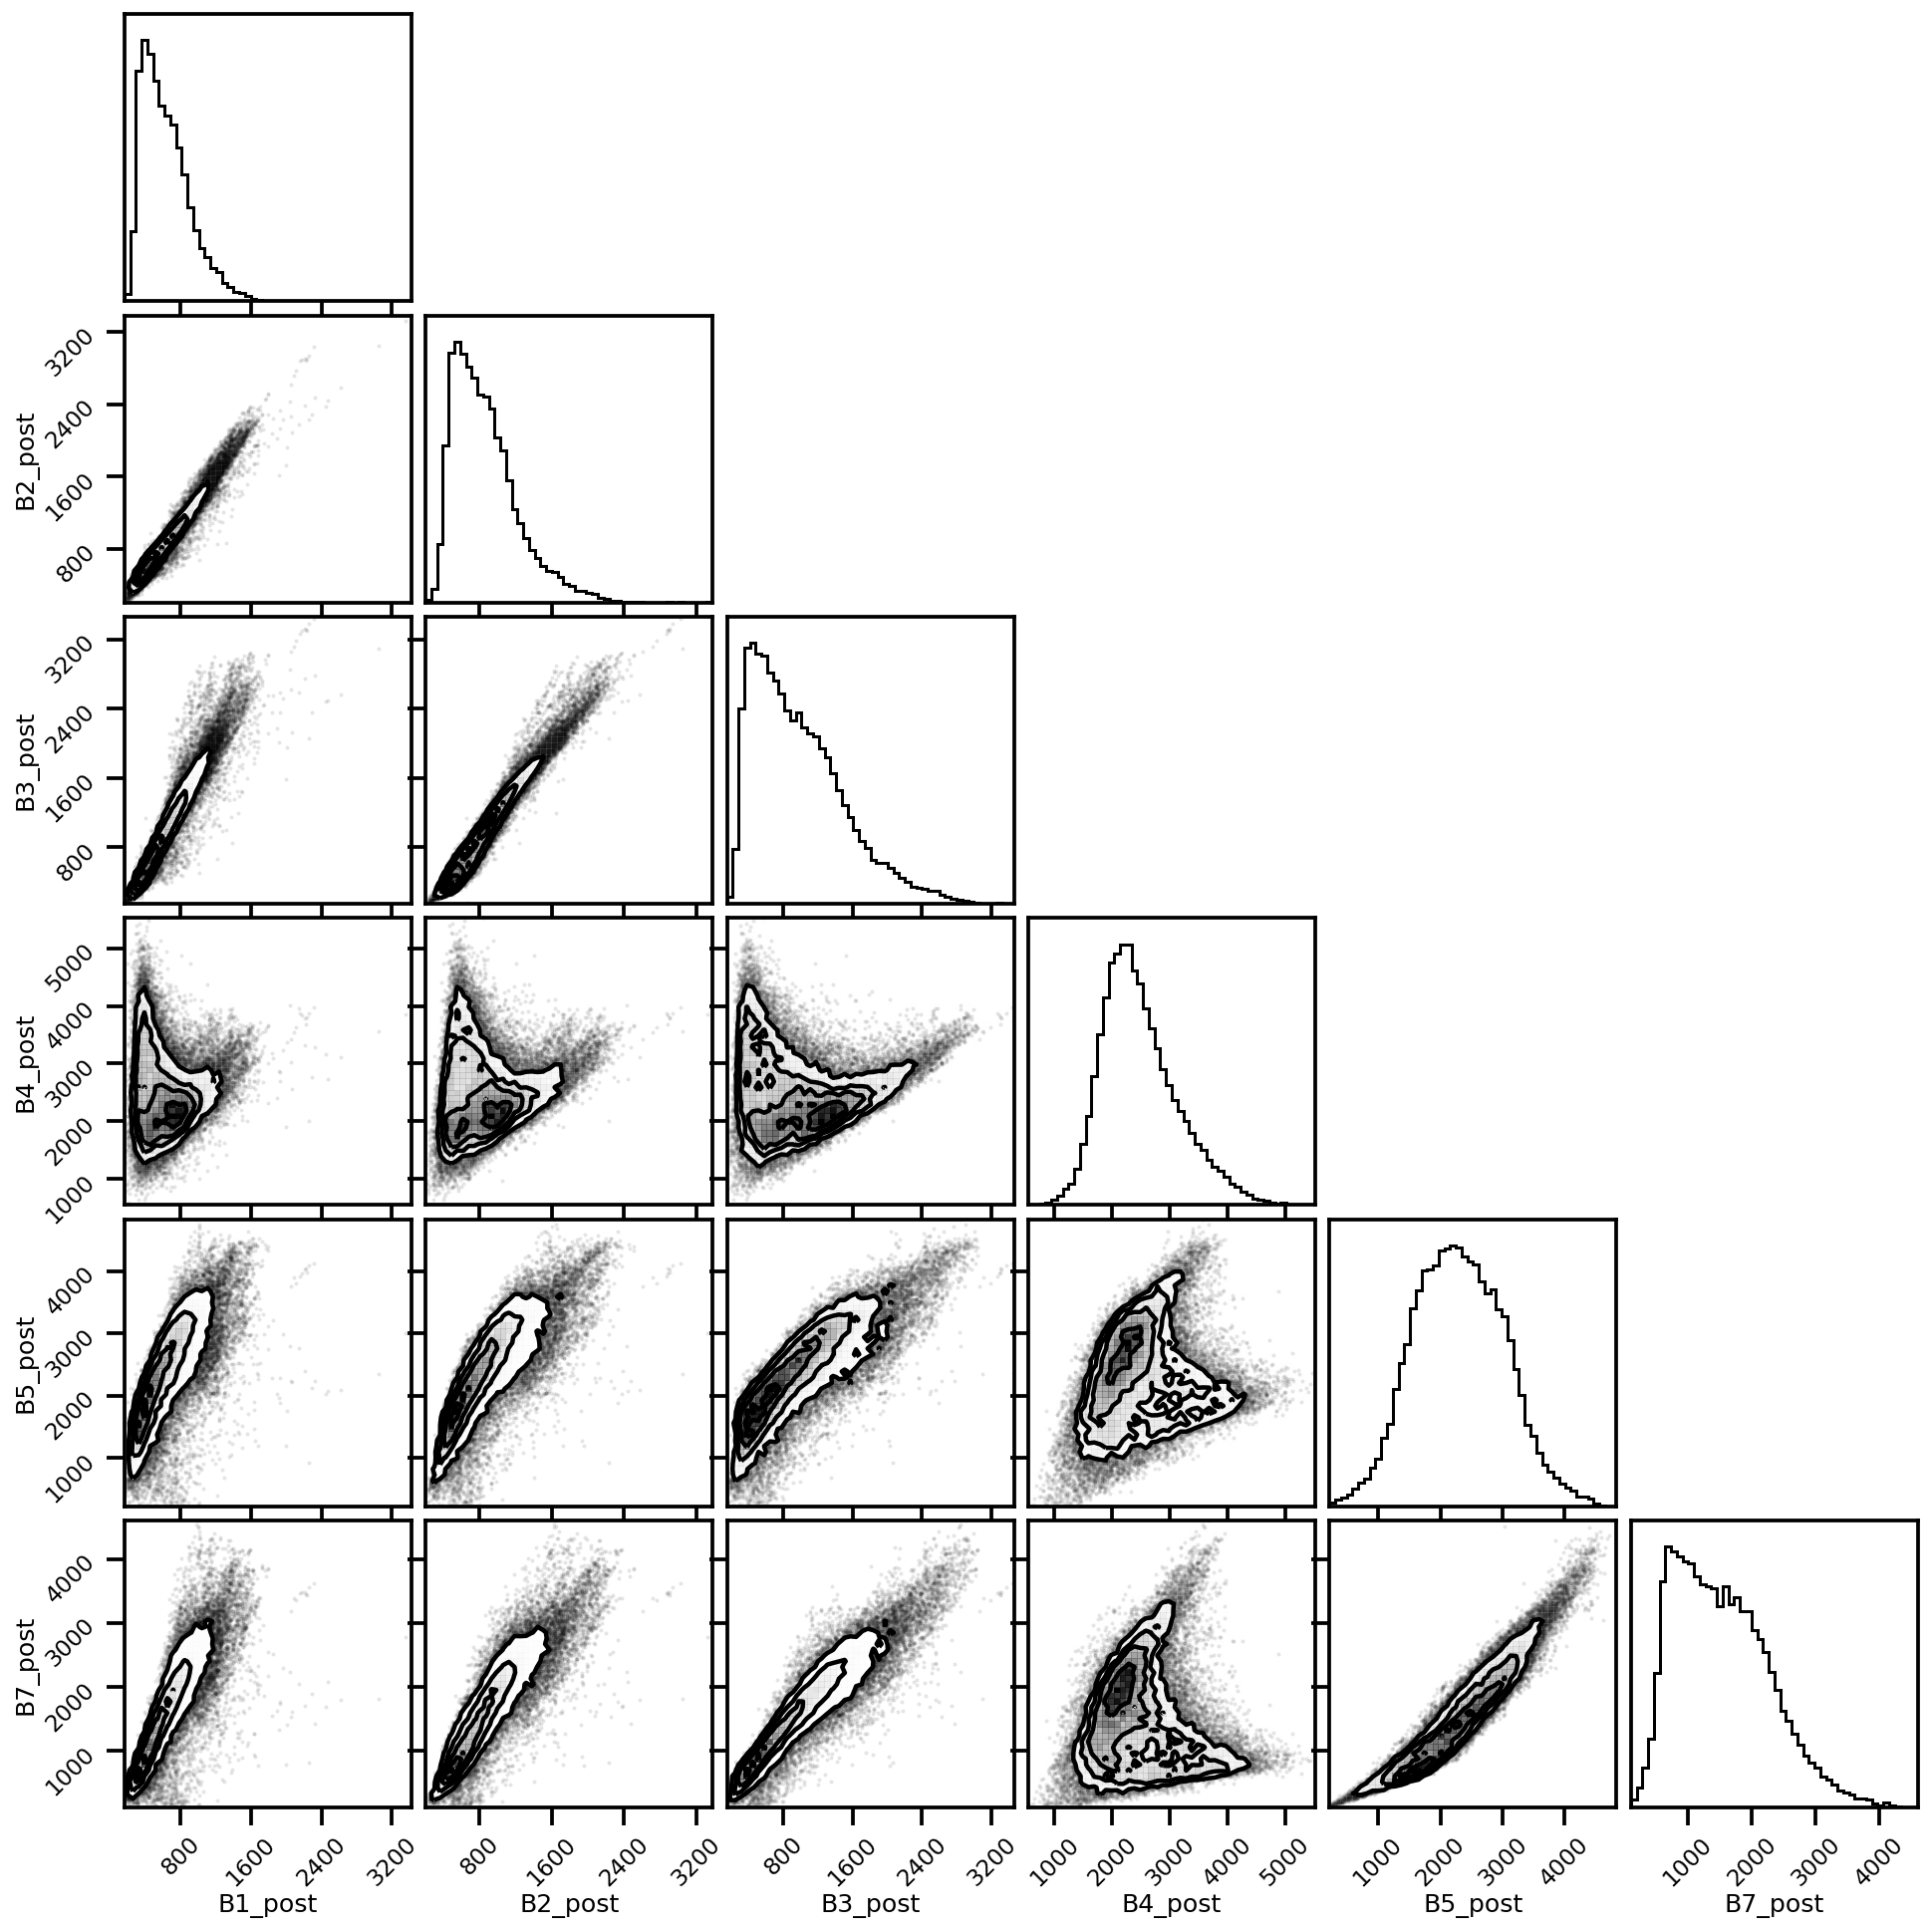

In [178]:
figure = corner.corner(X.dropna(), bins=50);

### Train-Test Split

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y['Lai'], train_size=1_000, random_state=123)

In [181]:
ytrain.index

MultiIndex([( 35.05787685686948, -102.66733092791495,  4.0, 10),
            (38.764774876788685,  -77.22434713579777, 12.0, 14),
            ( 48.49083445795075, -118.90976958008005,  7.0,  1),
            ( 35.20340393289684,  -103.5687903155289, 10.0,  7),
            (36.019972526161474,  -83.46988414863874, 10.0, 14),
            ( 41.10937776834064,  -76.93329298374303,  1.0, 14),
            ( 44.17757362125086, -102.73605204715011,  9.0, 10),
            (45.362002323362454,  -106.2691260595922,  8.0, 10),
            ( 36.31506909699475,  -97.26261702100986,  2.0, 10),
            (41.675316397335926,  -94.76440221587349, 10.0, 12),
            ...
            ( 33.11751584317131,  -85.31726953043052,  8.0,  5),
            (39.791549246537286, -104.74109176130487,  4.0, 12),
            ( 26.39497341446287,  -81.35974154624199,  1.0, 14),
            ( 39.37922253112644, -120.72481561164355,  6.0,  1),
            (40.074518561034935, -110.82088960422578, 10.0, 10),
         

In [133]:
!pip install xarray

     |████████████████████████████████| 720 kB 1.1 MB/s eta 0:00:01


In [206]:
ytest.shape, ytrain.shape

((40430,), (1000,))

In [182]:
import xarray as xr

In [203]:
xr_data_train = ytrain.to_xarray()
xr_data_train = xr_data_train.reindex(
    latitude=sorted(xr_data_train.latitude), 
    longitude=sorted(xr_data_train.longitude),
    month=sorted(xr_data_train.month),
    Land_Cover_Type_1=sorted(xr_data_train.Land_Cover_Type_1),
)

xr_data_test = ytest.to_xarray()
xr_data_test = xr_data_test.reindex(
    latitude=sorted(xr_data_test.latitude), 
    longitude=sorted(xr_data_test.longitude),
    month=sorted(xr_data_test.month),
    Land_Cover_Type_1=sorted(xr_data_test.Land_Cover_Type_1),
)

In [207]:
xr_data_test

<xarray.DataArray 'Lai' (latitude: 2597, longitude: 3265, month: 12, Land_Cover_Type_1: 15)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * latitude           (latitude) float64 25.33 25.53 25.59 ... 48.95 48.98
  * longitude          (longitude) float64 -124.2 -124.2 ... -67.88 -67.65
  * month              (month) float64 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
  * Land_Cover_Type_1  (Land_Cover_Type_1) int64 0 1 2 3 4 5 ... 10 11 12 14 16

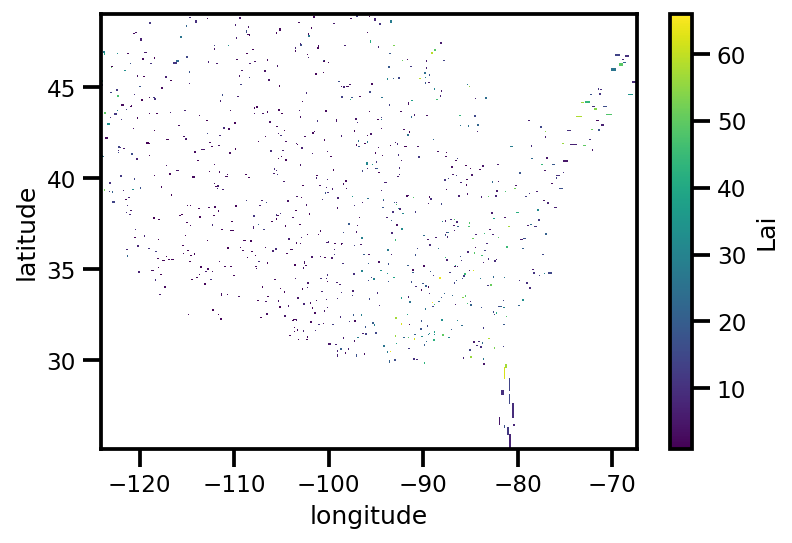

In [204]:
xr_data_train.mean(dim=['month', 'Land_Cover_Type_1']).plot.pcolormesh()

In [208]:
xr_data_test.mean(dim=['month']).plot.pcolormesh()

ValueError: DataArray must be 2d

### GP Model

In [109]:
input_dim = Xtrain.shape[-1]

# initialize kernel
length_scale = np.ones(shape=(input_dim,))
kernel = RBF(length_scale=np.exp(length_scale), variance=np.exp(1.0))

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean(input_dim=1)

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RBF).variance 2.7182817
(ExactGP).kernel(RBF).length_scale [2.7182817 2.7182817 2.7182817 2.7182817 2.7182817 2.7182817]
(ExactGP).noise [0.1]


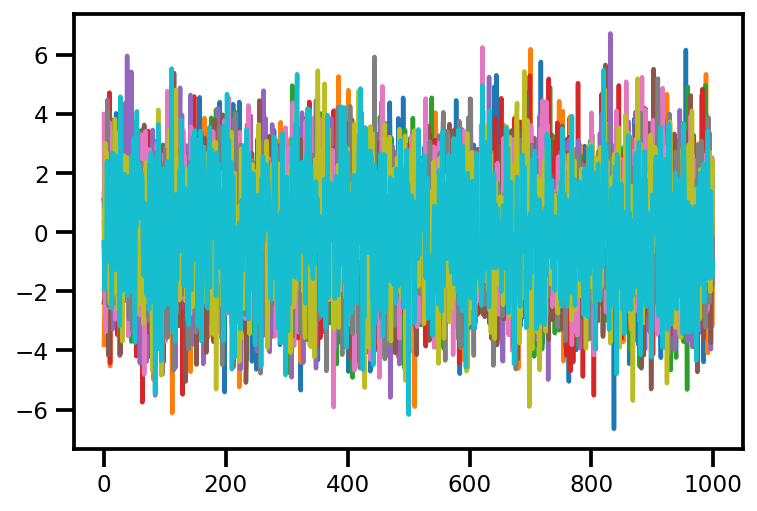

In [110]:
# generate random samples
dist = gp_model.forward(np.array(Xtrain.values))

seed = jax.random.PRNGKey(123)
y_samples = dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

In [94]:
from jaxkern.gp.optimize import optimize_model

In [95]:
jitted = True
n_epochs = 2_000
lr = 0.1

model, losses = optimize_model(
    model=gp_model,
    loss_f=negative_log_likelihood,
    X=np.array(Xtrain.values), y=np.array(ytrain.values).squeeze(),
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=True
)

100%|██████████| 2000/2000 [03:10<00:00, 10.49it/s]


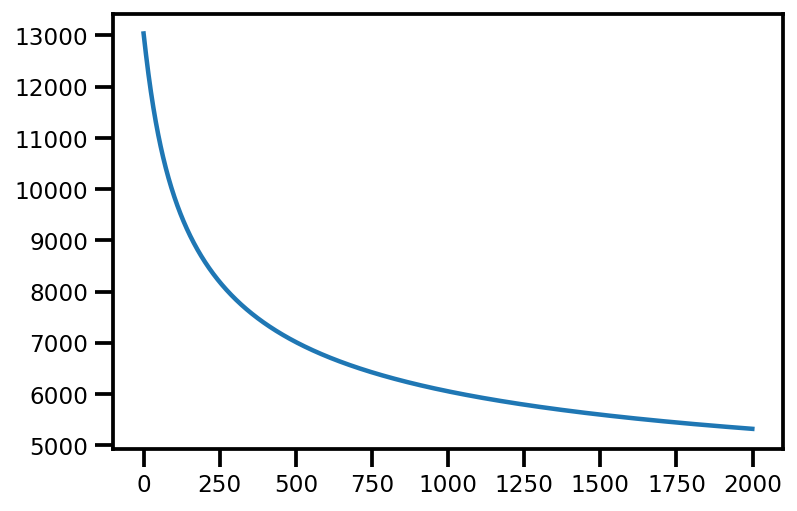

In [96]:
plt.plot(losses)

In [97]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RBF).variance 83.18577 83.18577 <class 'jax.interpreters.xla.DeviceArray'> ()
(ExactGP).kernel(RBF).length_scale [2.7182817 2.7182817 2.7182817 2.7182817 2.7182817 2.7182817] [2.782184 2.782184 2.782184 2.782184 2.782184 2.782184] <class 'jax.interpreters.xla.DeviceArray'> (6,)
(ExactGP).noise [3.1715398] [3.2126231] <class 'jax.interpreters.xla.DeviceArray'> (1,)


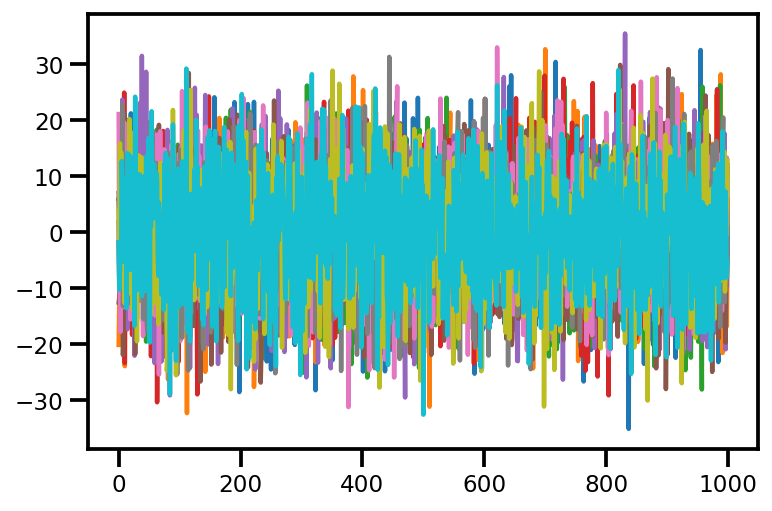

In [98]:
# generate random samples
dist = model.forward(np.array(Xtrain.values))

seed = jax.random.PRNGKey(123)
y_samples = dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

In [99]:
model.cache_factorizations(X=np.array(Xtrain.values), y=np.array(ytrain.values).squeeze(),)

mu, cov = model.predict_f(np.array(Xtrain.values))
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

In [100]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [101]:
r2 = r2_score(ytrain, mu)

print(r2)

0.9777329555176758
